In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential
from torch.nn import functional as F
import logging
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.preprocessing import KBinsDiscretizer
import sdgym
from sdv.metadata.single_table import SingleTableMetadata
from sdgym.datasets import load_dataset
from sklearn.preprocessing import LabelEncoder

In [2]:
LOGGER = logging.getLogger(__name__)
class BaseSynthesizer:
    """Base class for all default synthesizers of ``SDGym``."""

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        pass

    def sample(self, samples):
        pass

    def fit_sample(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        LOGGER.info("Fitting %s", self.__class__.__name__)
        self.fit(data, categorical_columns, ordinal_columns)

        LOGGER.info("Sampling %s", self.__class__.__name__)
        return self.sample(data.shape[0])

In [3]:
CATEGORICAL = "categorical"
CONTINUOUS = "continuous"
ORDINAL = "ordinal"
class Transformer:

    @staticmethod
    def get_metadata(data, categorical_columns=tuple(), ordinal_columns=tuple()):
        meta = []

        df = pd.DataFrame(data)
        for index in df:
            column = df[index]

            if index in categorical_columns:
                mapper = column.value_counts().index.tolist()
                meta.append({
                    "name": index,
                    "type": CATEGORICAL,
                    "size": len(mapper),
                    "i2s": mapper
                })
            elif index in ordinal_columns:
                value_count = list(dict(column.value_counts()).items())
                value_count = sorted(value_count, key=lambda x: -x[1])
                mapper = list(map(lambda x: x[0], value_count))
                meta.append({
                    "name": index,
                    "type": ORDINAL,
                    "size": len(mapper),
                    "i2s": mapper
                })
            else:
                meta.append({
                    "name": index,
                    "type": CONTINUOUS,
                    "min": column.min(),
                    "max": column.max(),
                })

        return meta

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        raise NotImplementedError

    def transform(self, data):
        raise NotImplementedError

    def inverse_transform(self, data):
        raise NotImplementedError


class DiscretizeTransformer(Transformer):
    """Discretize continuous columns into several bins.

    Attributes:
        meta
        column_index
        discretizer(sklearn.preprocessing.KBinsDiscretizer)

    Transformation result is a int array.

    """

    def __init__(self, n_bins):
        self.n_bins = n_bins
        self.meta = None
        self.column_index = None
        self.discretizer = None

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        self.column_index = [
            index for index, info in enumerate(self.meta) if info['type'] == CONTINUOUS]

        self.discretizer = KBinsDiscretizer(
            n_bins=self.n_bins, encode='ordinal', strategy='uniform')

        if not self.column_index:
            return

        self.discretizer.fit(data[:, self.column_index])

    def transform(self, data):
        """Transform data discretizing continous values.

        Args:
            data(pandas.DataFrame)

        Returns:
            numpy.ndarray

        """
        if self.column_index == []:
            return data.astype('int')

        data[:, self.column_index] = self.discretizer.transform(data[:, self.column_index])
        return data.astype('int')

    def inverse_transform(self, data):
        if self.column_index == []:
            return data

        data = data.astype('float32')
        data[:, self.column_index] = self.discretizer.inverse_transform(data[:, self.column_index])
        return data


class GeneralTransformer(Transformer):
    """Continuous and ordinal columns are normalized to [0, 1].
    Discrete columns are converted to a one-hot vector.
    """

    def __init__(self, act='sigmoid'):
        self.act = act
        self.meta = None
        self.output_dim = None

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        self.output_dim = 0
        for info in self.meta:
            if info['type'] in [CONTINUOUS, ORDINAL]:
                self.output_dim += 1
            else:
                self.output_dim += info['size']

    def transform(self, data):
        data_t = []
        self.output_info = []
        for id_, info in enumerate(self.meta):
            col = data[:, id_]
            if info['type'] == CONTINUOUS:
                col = (col - (info['min'])) / (info['max'] - info['min'])
                if self.act == 'tanh':
                    col = col * 2 - 1
                data_t.append(col.reshape([-1, 1]))
                self.output_info.append((1, self.act))

            elif info['type'] == ORDINAL:
                col = col / info['size']
                if self.act == 'tanh':
                    col = col * 2 - 1
                data_t.append(col.reshape([-1, 1]))
                self.output_info.append((1, self.act))

            else:
                col_t = np.zeros([len(data), info['size']])
                idx = list(map(info['i2s'].index, col))
                col_t[np.arange(len(data)), idx] = 1
                data_t.append(col_t)
                self.output_info.append((info['size'], 'softmax'))

        return np.concatenate(data_t, axis=1)

    def inverse_transform(self, data):
        data_t = np.zeros([len(data), len(self.meta)])

        data = data.copy()
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                current = data[:, 0]
                data = data[:, 1:]

                if self.act == 'tanh':
                    current = (current + 1) / 2

                current = np.clip(current, 0, 1)
                data_t[:, id_] = current * (info['max'] - info['min']) + info['min']

            elif info['type'] == ORDINAL:
                current = data[:, 0]
                data = data[:, 1:]

                if self.act == 'tanh':
                    current = (current + 1) / 2

                current = current * info['size']
                current = np.round(current).clip(0, info['size'] - 1)
                data_t[:, id_] = current
            else:
                current = data[:, :info['size']]
                data = data[:, info['size']:]
                idx = np.argmax(current, axis=1)
                data_t[:, id_] = list(map(info['i2s'].__getitem__, idx))

        return data_t


class GMMTransformer(Transformer):
    """
    Continuous columns are modeled with a GMM.
        and then normalized to a scalor [0, 1] and a n_cluster dimensional vector.

    Discrete and ordinal columns are converted to a one-hot vector.
    """

    def __init__(self, n_clusters=5):
        self.meta = None
        self.n_clusters = n_clusters

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        model = []

        self.output_info = []
        self.output_dim = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                gm = GaussianMixture(self.n_clusters)
                gm.fit(data[:, id_].reshape([-1, 1]))
                model.append(gm)
                self.output_info += [(1, 'tanh'), (self.n_clusters, 'softmax')]
                self.output_dim += 1 + self.n_clusters
            else:
                model.append(None)
                self.output_info += [(info['size'], 'softmax')]
                self.output_dim += info['size']

        self.model = model

    def transform(self, data):
        values = []
        for id_, info in enumerate(self.meta):
            current = data[:, id_]
            if info['type'] == CONTINUOUS:
                current = current.reshape([-1, 1])

                means = self.model[id_].means_.reshape((1, self.n_clusters))
                stds = np.sqrt(self.model[id_].covariances_).reshape((1, self.n_clusters))
                features = (current - means) / (2 * stds)

                probs = self.model[id_].predict_proba(current.reshape([-1, 1]))
                argmax = np.argmax(probs, axis=1)
                idx = np.arange((len(features)))
                features = features[idx, argmax].reshape([-1, 1])

                features = np.clip(features, -.99, .99)

                values += [features, probs]
            else:
                col_t = np.zeros([len(data), info['size']])
                idx = list(map(info['i2s'].index, current))
                col_t[np.arange(len(data)), idx] = 1
                values.append(col_t)

        return np.concatenate(values, axis=1)

    def inverse_transform(self, data, sigmas):
        data_t = np.zeros([len(data), len(self.meta)])

        st = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                u = data[:, st]
                v = data[:, st + 1:st + 1 + self.n_clusters]
                if sigmas is not None:
                    sig = sigmas[st]
                    u = np.random.normal(u, sig)

                u = np.clip(u, -1, 1)
                st += 1 + self.n_clusters
                means = self.model[id_].means_.reshape([-1])
                stds = np.sqrt(self.model[id_].covariances_).reshape([-1])
                p_argmax = np.argmax(v, axis=1)
                std_t = stds[p_argmax]
                mean_t = means[p_argmax]
                tmp = u * 2 * std_t + mean_t
                data_t[:, id_] = tmp

            else:
                current = data[:, st:st + info['size']]
                st += info['size']
                idx = np.argmax(current, axis=1)
                data_t[:, id_] = list(map(info['i2s'].__getitem__, idx))

        return data_t


class BGMTransformer(Transformer):
    """Model continuous columns with a BayesianGMM and normalized to a scalar [0, 1] and a vector.

    Discrete and ordinal columns are converted to a one-hot vector.
    """

    def __init__(self, n_clusters=10, eps=0.005):
        """n_cluster is the upper bound of modes."""
        self.meta = None
        self.n_clusters = n_clusters
        self.eps = eps

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        model = []

        self.output_info = []
        self.output_dim = 0
        self.components = []
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                gm = BayesianGaussianMixture(
                    n_components=self.n_clusters,
                    weight_concentration_prior_type='dirichlet_process',
                    weight_concentration_prior=0.001,
                    n_init=1)
                gm.fit(data.iloc[:, id_].values.reshape([-1, 1]))
                model.append(gm)
                comp = gm.weights_ > self.eps
                self.components.append(comp)

                self.output_info += [(1, 'tanh'), (np.sum(comp), 'softmax')]
                self.output_dim += 1 + np.sum(comp)
            else:
                model.append(None)
                self.components.append(None)
                self.output_info += [(info['size'], 'softmax')]
                self.output_dim += info['size']

        self.model = model

    def transform(self, data):
        values = []
        c_model = []
        for id_, info in enumerate(self.meta):
            current = data.iloc[:, id_]
            if info['type'] == CONTINUOUS:
                current = current.values.reshape([-1, 1])

                means = self.model[id_].means_.reshape((1, self.n_clusters))
                stds = np.sqrt(self.model[id_].covariances_).reshape((1, self.n_clusters))
                features = (current - means) / (4 * stds)

                probs = self.model[id_].predict_proba(current.reshape([-1, 1]))

                n_opts = sum(self.components[id_])
                features = features[:, self.components[id_]]
                probs = probs[:, self.components[id_]]

                opt_sel = np.zeros(len(data), dtype='int')
                for i in range(len(data)):
                    pp = probs[i] + 1e-6
                    pp = pp / sum(pp)
                    opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)

                idx = np.arange((len(features)))
                features = features[idx, opt_sel].reshape([-1, 1])
                features = np.clip(features, -.99, .99)

                probs_onehot = np.zeros_like(probs)
                probs_onehot[np.arange(len(probs)), opt_sel] = 1
                values += [features, probs_onehot]
                c_model.append(None)
            else:
                label_encoder = LabelEncoder()
                current_encoded = label_encoder.fit_transform(current)
                col_t = np.zeros([len(data), info['size']])
                idx = list(map(info['i2s'].index, current))
                # col_t[np.arange(len(data)), current_encoded] = 1
                col_t[np.arange(len(data)), idx] = 1
                c_model.append(label_encoder)
                values.append(col_t)
        self.c_model = c_model
        return np.concatenate(values, axis=1)

    def inverse_transform(self, data, sigmas):
        data_t = np.zeros([len(data), len(self.meta)])
        data_t = data_t.astype(object)
        st = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                u = data[:, st]
                v = data[:, st + 1:st + 1 + np.sum(self.components[id_])]

                if sigmas is not None:
                    sig = sigmas[st]
                    u = np.random.normal(u, sig)

                u = np.clip(u, -1, 1)
                v_t = np.ones((data.shape[0], self.n_clusters)) * -100
                v_t[:, self.components[id_]] = v
                v = v_t
                st += 1 + np.sum(self.components[id_])
                means = self.model[id_].means_.reshape([-1])
                stds = np.sqrt(self.model[id_].covariances_).reshape([-1])
                p_argmax = np.argmax(v, axis=1)
                std_t = stds[p_argmax]
                mean_t = means[p_argmax]
                tmp = u * 4 * std_t + mean_t
                data_t[:, id_] = tmp

            else:
                current = data[:, st:st + info['size']]
                st += info['size']
                idx = np.argmax(current, axis=1)
                data_t[:, id_] = list(map(info['i2s'].__getitem__, idx))

        return data_t


class CatigoricalTransformer(Transformer):
    """Model continuous columns into categorical columns and convert to a one-hot vector.
    """

    def __init__(self, n_clusters=10, eps=0.005):
        """n_cluster is the upper bound of modes."""
        self.meta = None
        self.n_clusters = n_clusters
        self.eps = eps

    def fit(self, data, categorical_columns=tuple(), ordinal_columns=tuple()):
        self.meta = self.get_metadata(data, categorical_columns, ordinal_columns)
        model = []

        self.output_info = []
        self.output_dim = 0
        self.components = []
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                gm = BayesianGaussianMixture(
                    n_components=self.n_clusters,
                    weight_concentration_prior_type='dirichlet_process',
                    weight_concentration_prior=0.001,
                    n_init=1)
                gm.fit(data.iloc[:, id_].values.reshape([-1, 1]))
                model.append(gm)
                comp = gm.weights_ > self.eps
                self.components.append(comp)
                self.output_info += [(20, 'softmax'), (np.sum(comp), 'softmax')]
                self.output_dim += 20 + np.sum(comp)
                # self.output_info += [(20, 'softmax')]
                # self.output_dim += 10
            else:
                model.append(None)
                self.components.append(None)
                self.output_info += [(info['size'], 'softmax')]
                self.output_dim += info['size']

        self.model = model

    def transform(self, data):
        values = []
        # c_model = []
        for id_, info in enumerate(self.meta):
            current = data.iloc[:, id_]
            if info['type'] == CONTINUOUS:
                current = current.values.reshape([-1, 1])

                means = self.model[id_].means_.reshape((1, self.n_clusters))
                stds = np.sqrt(self.model[id_].covariances_).reshape((1, self.n_clusters))
                features = (current - means) / (4 * stds)

                probs = self.model[id_].predict_proba(current.reshape([-1, 1]))

                n_opts = sum(self.components[id_])
                features = features[:, self.components[id_]]
                probs = probs[:, self.components[id_]]

                opt_sel = np.zeros(len(data), dtype='int')
                for i in range(len(data)):
                    pp = probs[i] + 1e-6
                    pp = pp / sum(pp)
                    opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)

                idx = np.arange((len(features)))
                features = features[idx, opt_sel].reshape([-1, 1])
                features = np.clip(features, -.99, .99)

                probs_onehot = np.zeros_like(probs)
                probs_onehot[np.arange(len(probs)), opt_sel] = 1
                
                col_t = np.zeros([len(data), 20])
                for i in range(len(data)):
                    if(features[i]<0):
                        idx = int(features[i]*10)+9
                    else:
                        idx = int(features[i]*10)+10
                    col_t[i,idx]=1
                # col_t[:,20]=probs_onehot
                # values.append(col_t)
                values += [col_t, probs_onehot]
                # values += [features, probs_onehot]
            else:
                # label_encoder = LabelEncoder()
                # current_encoded = label_encoder.fit_transform(current)
                col_t = np.zeros([len(data), info['size']])
                idx = list(map(info['i2s'].index, current))
                # col_t[np.arange(len(data)), current_encoded] = 1
                col_t[np.arange(len(data)), idx] = 1
                # c_model.append(label_encoder)
                values.append(col_t)
        # self.c_model = c_model
        return np.concatenate(values, axis=1)

    def inverse_transform(self, data, sigmas):
        data_t = np.zeros([len(data), len(self.meta)])
        data_t = data_t.astype(object)
        st = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == CONTINUOUS:
                current = data[:, st:st + 20]
                softmax_probs = np.exp(current) / np.sum(np.exp(current), axis=1, keepdims=True)
                max_indices = np.argmax(softmax_probs, axis=1)
                u = []
                for i in max_indices:
                    random_value = np.random.uniform(i-10, i-9)
                    u.append(random_value)
                v = data[:, st + 20:st + 20 + np.sum(self.components[id_])]
                # u = data[:, st]
                # v = data[:, st + 1:st + 1 + np.sum(self.components[id_])]

                if sigmas is not None:
                    sig = sigmas[st]
                    u = np.random.normal(u, sig)

                u = np.clip(u, -1, 1)
                v_t = np.ones((data.shape[0], self.n_clusters)) * -100
                v_t[:, self.components[id_]] = v
                v = v_t
                st += 20 + np.sum(self.components[id_])
                means = self.model[id_].means_.reshape([-1])
                stds = np.sqrt(self.model[id_].covariances_).reshape([-1])
                p_argmax = np.argmax(v, axis=1)
                std_t = stds[p_argmax]
                mean_t = means[p_argmax]
                tmp = u * 4 * std_t + mean_t
                data_t[:, id_] = tmp

            else:
                current = data[:, st:st + info['size']]
                st += info['size']
                idx = np.argmax(current, axis=1)
                data_t[:, id_] = list(map(info['i2s'].__getitem__, idx))

        return data_t

In [4]:
data, metadata = load_dataset(dataset='adult', modality='single-table')

metadata_obj = SingleTableMetadata.load_from_dict(metadata)
data_dict = metadata_obj.columns
categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'categorical']
categorical_columns_tuple = tuple(categorical_columns)
ordinal_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'ordinal']
ordinal_columns_tuple = tuple(ordinal_columns)

In [5]:
transformer = CatigoricalTransformer()
transformer.fit(data, categorical_columns, ordinal_columns)
a = transformer.transform(data)
transformer.inverse_transform(a,None)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.wa

In [4]:
class Discriminator(Module):
    def __init__(self, input_dim, dis_dims, pack=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pack
        self.pack = pack
        self.packdim = dim
        seq = []
        for item in list(dis_dims):
            seq += [
                Linear(dim, item),
                LeakyReLU(0.2),
                Dropout(0.5)
            ]
            dim = item
        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def forward(self, input):
        assert input.size()[0] % self.pack == 0
        return self.seq(input.view(-1, self.packdim))

In [5]:
class Residual(Module):
    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input):
        out = self.fc(input)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input], dim=1)


class Generator(Module):
    def __init__(self, embedding_dim, gen_dims, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(gen_dims):
            seq += [
                Residual(dim, item)
            ]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input):
        data = self.seq(input)
        return data

In [6]:
def apply_activate(data, output_info):
    data_t = []
    st = 0
    for item in output_info:
        if item[1] == 'tanh':
            ed = st + item[0]
            data_t.append(torch.tanh(data[:, st:ed]))
            st = ed
        elif item[1] == 'softmax':
            ed = st + item[0]
            data_t.append(F.gumbel_softmax(data[:, st:ed], tau=0.2))
            st = ed
        else:
            assert 0
    return torch.cat(data_t, dim=1)

def random_choice_prob_index(a, axis=1):
    r = np.expand_dims(np.random.rand(a.shape[1 - axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

In [7]:
class Cond(object):
    def __init__(self, data, output_info):
        # self.n_col = self.n_opt = 0
        # return
        self.model = []

        st = 0
        skip = False
        max_interval = 0
        counter = 0
        for item in output_info:
            if item[1] == 'tanh':
                st += item[0]
                skip = True
                continue
            elif item[1] == 'softmax':
                if skip:
                    skip = False
                    st += item[0]
                    continue

                ed = st + item[0]
                max_interval = max(max_interval, ed - st)
                counter += 1
                self.model.append(np.argmax(data[:, st:ed], axis=-1))
                st = ed
            else:
                assert 0
        assert st == data.shape[1]

        self.interval = []
        self.n_col = 0
        self.n_opt = 0
        skip = False
        st = 0
        self.p = np.zeros((counter, max_interval))
        for item in output_info:
            if item[1] == 'tanh':
                skip = True
                st += item[0]
                continue
            elif item[1] == 'softmax':
                if skip:
                    st += item[0]
                    skip = False
                    continue
                ed = st + item[0]
                tmp = np.sum(data[:, st:ed], axis=0)
                tmp = np.log(tmp + 1)
                tmp = tmp / np.sum(tmp)
                self.p[self.n_col, :item[0]] = tmp
                self.interval.append((self.n_opt, item[0]))
                self.n_opt += item[0]
                self.n_col += 1
                st = ed
            else:
                assert 0
        self.interval = np.asarray(self.interval)

    def sample(self, batch):
        if self.n_col == 0:
            return None
        batch = batch
        idx = np.random.choice(np.arange(self.n_col), batch)

        vec1 = np.zeros((batch, self.n_opt), dtype='float32')
        mask1 = np.zeros((batch, self.n_col), dtype='float32')
        mask1[np.arange(batch), idx] = 1
        opt1prime = random_choice_prob_index(self.p[idx])
        opt1 = self.interval[idx, 0] + opt1prime
        vec1[np.arange(batch), opt1] = 1

        return vec1, mask1, idx, opt1prime

    def sample_zero(self, batch):
        if self.n_col == 0:
            return None
        vec = np.zeros((batch, self.n_opt), dtype='float32')
        idx = np.random.choice(np.arange(self.n_col), batch)
        for i in range(batch):
            col = idx[i]
            pick = int(np.random.choice(self.model[col]))
            vec[i, pick + self.interval[col, 0]] = 1
        return vec

In [8]:
def cond_loss(data, output_info, c, m):
    loss = []
    st = 0
    st_c = 0
    skip = False
    for item in output_info:
        if item[1] == 'tanh':
            st += item[0]
            skip = True

        elif item[1] == 'softmax':
            if skip:
                skip = False
                st += item[0]
                continue

            ed = st + item[0]
            ed_c = st_c + item[0]
            tmp = F.cross_entropy(
                data[:, st:ed],
                torch.argmax(c[:, st_c:ed_c], dim=1),
                reduction='none'
            )
            loss.append(tmp)
            st = ed
            st_c = ed_c

        else:
            assert 0
    loss = torch.stack(loss, dim=1)

    return (loss * m).sum() / data.size()[0]

In [9]:
class Sampler(object):
    """docstring for Sampler."""

    def __init__(self, data, output_info):
        super(Sampler, self).__init__()
        self.data = data
        self.model = []
        self.n = len(data)

        st = 0
        skip = False
        for item in output_info:
            if item[1] == 'tanh':
                st += item[0]
                skip = True
            elif item[1] == 'softmax':
                if skip:
                    skip = False
                    st += item[0]
                    continue
                ed = st + item[0]
                tmp = []
                for j in range(item[0]):
                    tmp.append(np.nonzero(data[:, st + j])[0])
                self.model.append(tmp)
                st = ed
            else:
                assert 0
        assert st == data.shape[1]

    def sample(self, n, col, opt):
        if col is None:
            idx = np.random.choice(np.arange(self.n), n)
            return self.data[idx]
        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self.model[c][o]))
        return self.data[idx]

In [10]:
def calc_gradient_penalty(netD, real_data, fake_data, device='cpu', pac=10, lambda_=10):
    alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
    alpha = alpha.repeat(1, pac, real_data.size(1))
    alpha = alpha.view(-1, real_data.size(1))

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    # interpolates = torch.Variable(interpolates, requires_grad=True, device=device)

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates,
        grad_outputs=torch.ones(disc_interpolates.size(), device=device),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = (
        (gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1) ** 2).mean() * lambda_
    return gradient_penalty

In [25]:
class ctGANSynthesizer(BaseSynthesizer):
    """docstring for IdentitySynthesizer."""

    def __init__(self,
                embedding_dim=128,
                gen_dim=(256, 256),
                dis_dim=(256, 256),
                l2scale=1e-6,
                batch_size=500,
                epochs=300):

        self.embedding_dim = embedding_dim
        self.gen_dim = gen_dim
        self.dis_dim = dis_dim

        self.l2scale = l2scale
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.column_names = None

    def fit(self, train_data, categorical_columns=tuple(), ordinal_columns=tuple()):
        gen_dim=(256, 256)
        dis_dim=(256, 256)
        l2scale=1e-6
        batch_size=500
        epochs=100
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.column_names = list(train_data.columns)
        self.transformer = CatigoricalTransformer()
        self.transformer.fit(train_data, categorical_columns, ordinal_columns)
        new_train_data = self.transformer.transform(train_data)

        data_sampler = Sampler(new_train_data, self.transformer.output_info)

        data_dim = self.transformer.output_dim
        self.cond_generator = Cond(new_train_data, self.transformer.output_info)
        e_dim = 128
        self.generator = Generator(
            e_dim + self.cond_generator.n_opt,
            gen_dim,
            data_dim).to(self.device)

        discriminator = Discriminator(
            data_dim + self.cond_generator.n_opt,
            dis_dim).to(self.device)

        optimizerG = optim.Adam(
            self.generator.parameters(), lr=2e-4, betas=(0.5, 0.9), weight_decay=l2scale)
        optimizerD = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.9))

        assert batch_size % 2 == 0
        # mean = torch.zeros(self.batch_size, self.embedding_dim, device=self.device)
        mean = torch.zeros(batch_size, e_dim, device=self.device)
        std = mean + 1

        steps_per_epoch = len(new_train_data) // batch_size
        for i in range(epochs):
            for id_ in range(steps_per_epoch):
                fakez = torch.normal(mean=mean, std=std)

                condvec = self.cond_generator.sample(batch_size)
                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                    real = data_sampler.sample(batch_size, col, opt)
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self.device)
                    m1 = torch.from_numpy(m1).to(self.device)
                    fakez = torch.cat([fakez, c1], dim=1)

                    perm = np.arange(batch_size)
                    np.random.shuffle(perm)
                    real = data_sampler.sample(batch_size, col[perm], opt[perm])
                    c2 = c1[perm]

                fake = self.generator(fakez)
                fakeact = apply_activate(fake, self.transformer.output_info)

                real = torch.from_numpy(real.astype('float32')).to(self.device)

                if c1 is not None:
                    fake_cat = torch.cat([fakeact, c1], dim=1)
                    real_cat = torch.cat([real, c2], dim=1)
                else:
                    real_cat = real
                    fake_cat = fake

                y_fake = discriminator(fake_cat)
                y_real = discriminator(real_cat)

                loss_d = -(torch.mean(y_real) - torch.mean(y_fake))
                pen = calc_gradient_penalty(discriminator, real_cat, fake_cat, self.device)

                optimizerD.zero_grad()
                pen.backward(retain_graph=True)
                loss_d.backward()
                optimizerD.step()

                fakez = torch.normal(mean=mean, std=std)
                condvec = self.cond_generator.sample(batch_size)

                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self.device)
                    m1 = torch.from_numpy(m1).to(self.device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = self.generator(fakez)
                fakeact = apply_activate(fake, self.transformer.output_info)

                if c1 is not None:
                    y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
                else:
                    y_fake = discriminator(fakeact)

                if condvec is None:
                    cross_entropy = 0
                else:
                    cross_entropy = cond_loss(fake, self.transformer.output_info, c1, m1)

                loss_g = -torch.mean(y_fake) + cross_entropy

                optimizerG.zero_grad()
                loss_g.backward()
                optimizerG.step()

    def sample(self, n):
        self.gen_dim=(256, 256)
        self.dis_dim=(256, 256)
        self.l2scale=1e-6
        self.batch_size=500
        self.epochs=100
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        output_info = self.transformer.output_info
        steps = n // self.batch_size + 1
        new_data = []
        e_dim = 128
        for i in range(steps):
            mean = torch.zeros(self.batch_size, e_dim)
            std = mean + 1
            fakez = torch.normal(mean=mean, std=std).to(self.device)

            condvec = self.cond_generator.sample_zero(self.batch_size)
            if condvec is None:
                pass
            else:
                c1 = condvec
                c1 = torch.from_numpy(c1).to(self.device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake = self.generator(fakez)
            fakeact = apply_activate(fake, output_info)
            new_data.append(fakeact.detach().cpu().numpy())

        new_data = np.concatenate(new_data, axis=0)
        new_data = new_data[:n]
        inv_data = self.transformer.inverse_transform(new_data, None)
        df_inv = pd.DataFrame(inv_data)
        df_inv.columns = self.column_names
        return df_inv

In [12]:
def get_trained_synthesizer(data, metadata):
    metadata_obj = SingleTableMetadata.load_from_dict(metadata)
    model = ctGANSynthesizer(metadata_obj)
    data_dict = metadata_obj.columns
    categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'categorical']
    categorical_columns_tuple = tuple(categorical_columns)
    ordinal_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'ordinal']
    ordinal_columns_tuple = tuple(ordinal_columns)
    model.fit(data, categorical_columns_tuple, ordinal_columns_tuple)
    return model

def sample_from_synthesizer(synthesizer, n_samples):
    return synthesizer.sample(n_samples)

In [13]:
from sdgym import create_single_table_synthesizer

MyCustomSynthesizerClass = create_single_table_synthesizer(
    get_trained_synthesizer_fn=get_trained_synthesizer,
    sample_from_synthesizer_fn=sample_from_synthesizer,
    display_name='newCTGANSynthesizer'
)

In [45]:
baseline_synthesizers = ['UniformSynthesizer']
scores = sdgym.benchmark_single_table(
    synthesizers=baseline_synthesizers, custom_synthesizers=[MyCustomSynthesizerClass], sdv_datasets=['KRK_v1'])
scores

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(

,Synthesizer,Dataset,Dataset_Size_MB,Train_Time,Peak_Memory_MB,Synthesizer_Size_MB,Sample_Time,Evaluate_Time,Quality_Score,NewRowSynthesis
0,UniformSynthesizer,KRK_v1,0.072128,0.125517,0.277001,0.067544,0.038362,17.311470,0.946663,1.0
1,Custom:newCTGANSynthesizer,KRK_v1,0.072128,51.838104,5.221723,1.865947,0.374197,18.038991,0.898083,1.0


In [32]:
data, metadata = load_dataset(dataset='KRK_v1', modality='single-table')

metadata_obj = SingleTableMetadata.load_from_dict(metadata)
data_dict = metadata_obj.columns
categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'categorical']
categorical_columns_tuple = tuple(categorical_columns)
ordinal_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'ordinal']
ordinal_columns_tuple = tuple(ordinal_columns)

synthesizer = ctGANSynthesizer()
synthesizer.fit(data, categorical_columns, ordinal_columns)
result = synthesizer.sample(100)
result

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(

,id,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,class,add_numerical
0,-254.615833,3.852903,7.692682,8.32062,0.181873,5.342221,6.28384,legal,31.56223
1,-153.322531,4.13039,3.033575,0.778956,8.843993,4.535534,8.09825,legal,1140.2548
2,261.400073,-1.821808,6.368859,3.816881,1.031943,4.996293,2.421176,illegal,450.915495
3,574.052893,4.193241,4.145313,4.050704,-1.785956,2.101426,8.831376,legal,1225.867547
4,1252.119674,4.856897,-1.839862,4.611003,4.293879,2.512886,8.831376,illegal,1268.867533
...,...,...,...,...,...,...,...,...,...
95,121.854056,-1.821808,5.995596,7.176139,-1.789135,2.249111,5.065655,illegal,566.469884
96,565.417064,4.856036,1.002557,2.201457,3.853701,2.642426,5.777754,legal,450.915495
97,-198.920544,3.141476,2.883879,5.927045,4.965909,2.982903,3.095656,illegal,-128.905587
98,-129.744192,4.193241,4.694695,8.787777,3.072686,6.810465,8.411717,legal,-218.010217


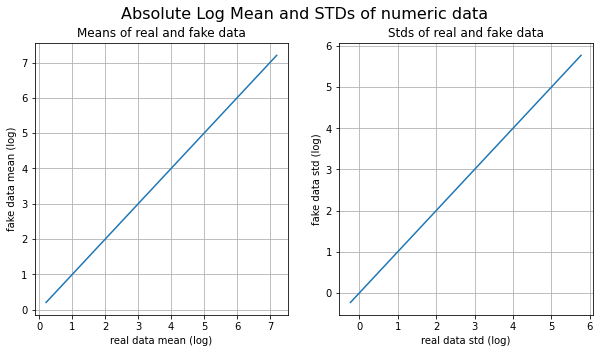

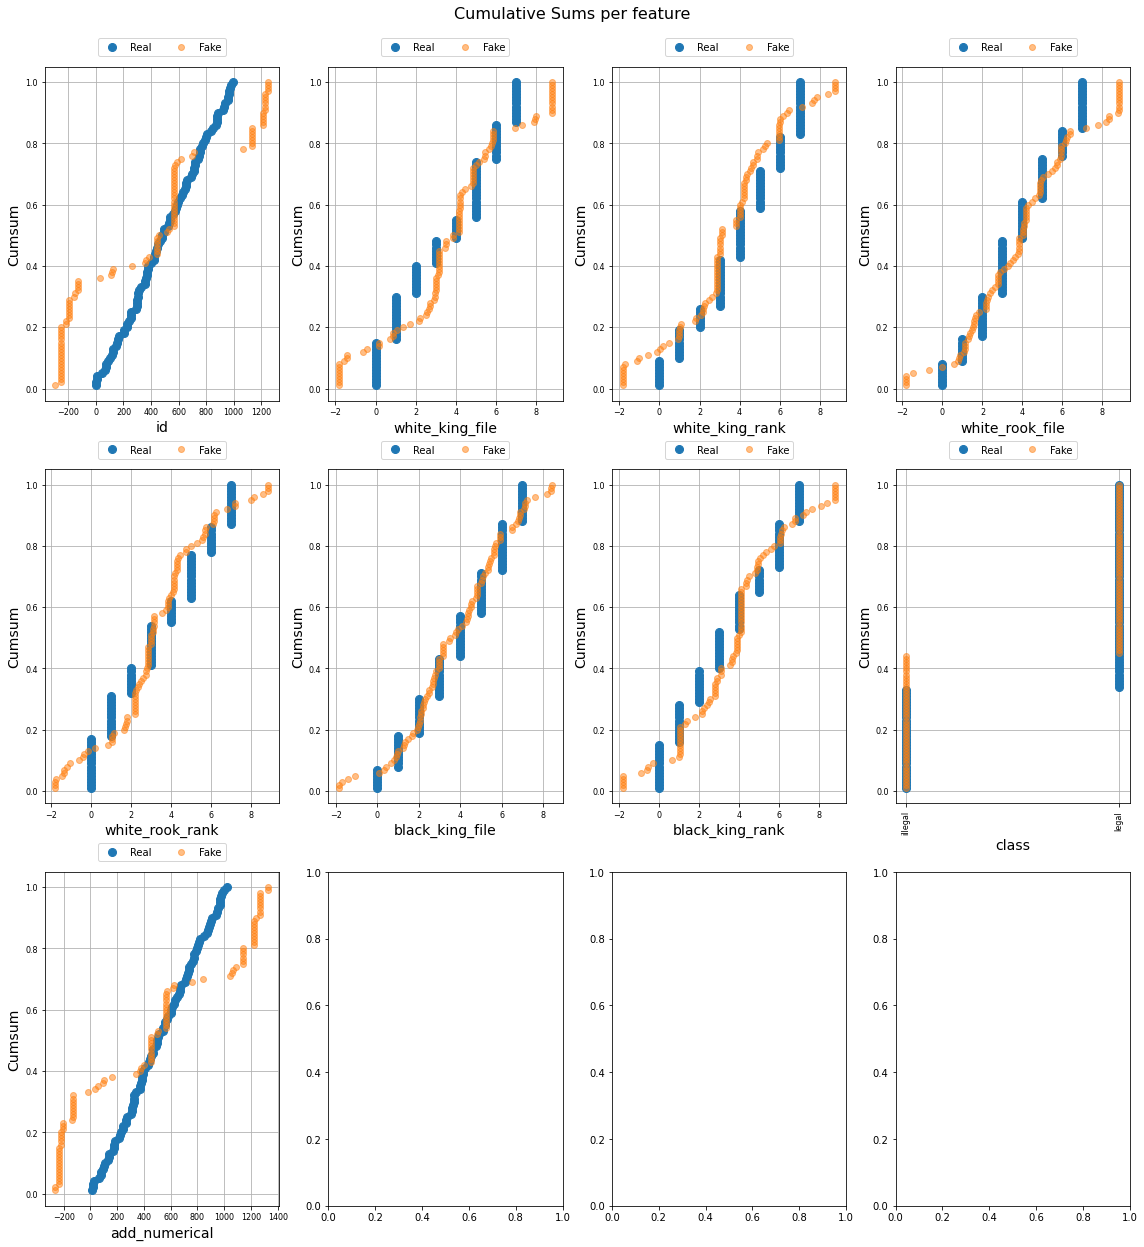

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')


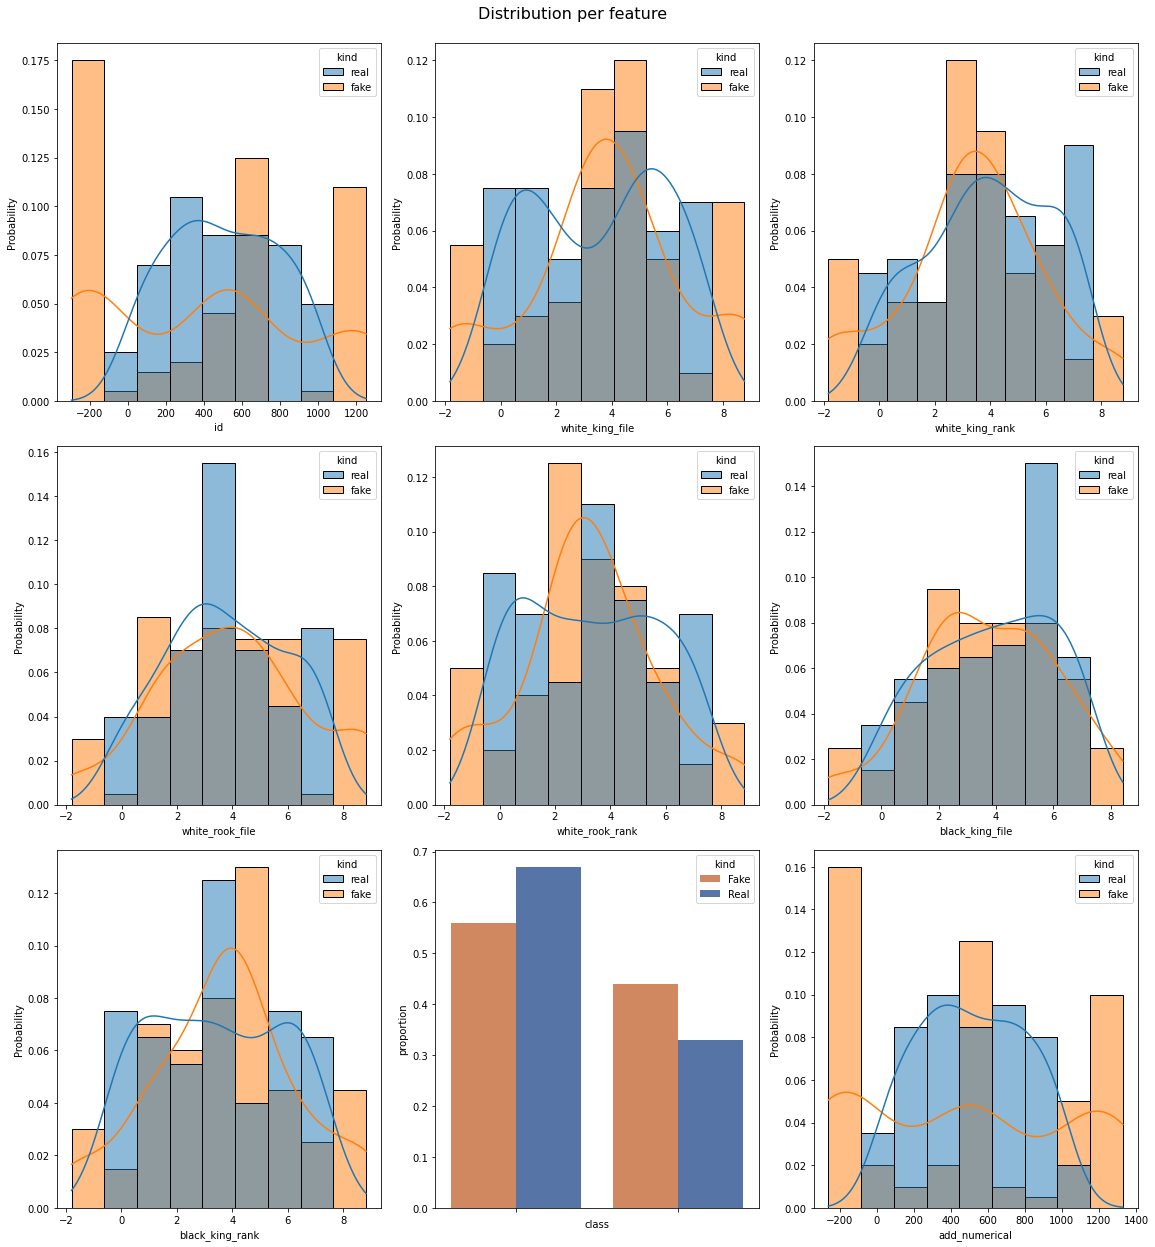

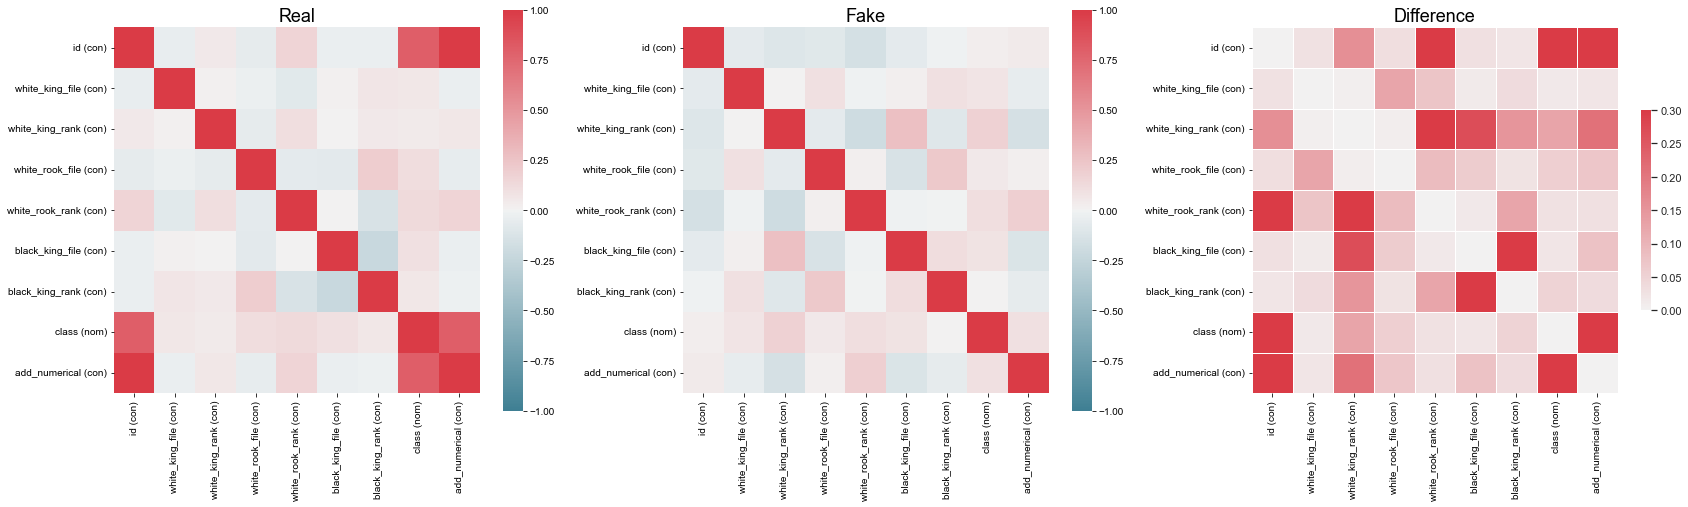

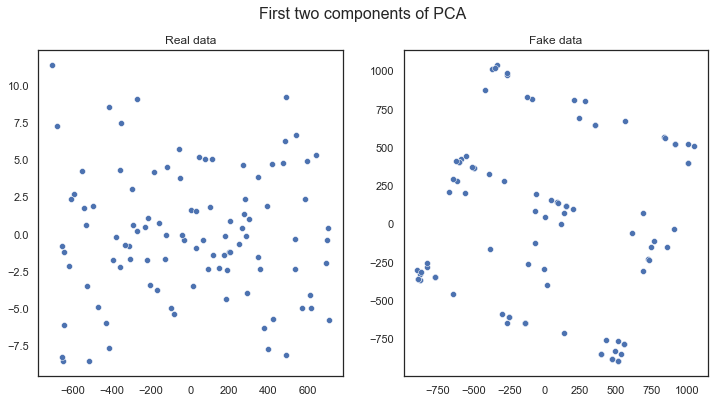

In [34]:
from table_evaluator import TableEvaluator
data, metadata = load_dataset(dataset='KRK_v1', modality='single-table')
table_evaluator = TableEvaluator(data, result)
table_evaluator.visual_evaluation()

In [38]:
data, metadata = load_dataset(dataset='KRK_v1', modality='single-table')

metadata_obj = SingleTableMetadata.load_from_dict(metadata)
data_dict = metadata_obj.columns
categorical_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'categorical']
categorical_columns_tuple = tuple(categorical_columns)
ordinal_columns = [column for column, info in data_dict.items() if info.get('sdtype') == 'ordinal']
ordinal_columns_tuple = tuple(ordinal_columns)

train_data = data
column_names = list(train_data.columns)
transformer = CatigoricalTransformer()
transformer.fit(train_data, categorical_columns, ordinal_columns)
train_data = transformer.transform(train_data)

data_sampler = Sampler(train_data, transformer.output_info)

gen_dim=(256, 256)
dis_dim=(256, 256)
l2scale=1e-6
batch_size=500
epochs=100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_dim = transformer.output_dim
cond_generator = Cond(train_data, transformer.output_info)
e_dim = 128
generator = Generator(
    e_dim + cond_generator.n_opt,
    gen_dim,
    data_dim).to(device)

discriminator = Discriminator(
    data_dim + cond_generator.n_opt,
    dis_dim).to(device)

optimizerG = optim.Adam(
    generator.parameters(), lr=2e-4, betas=(0.5, 0.9), weight_decay=l2scale)
optimizerD = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.9))

assert batch_size % 2 == 0
# mean = torch.zeros(self.batch_size, self.embedding_dim, device=self.device)
mean = torch.zeros(batch_size, e_dim, device=device)
std = mean + 1

steps_per_epoch = len(train_data) // batch_size
for i in range(epochs):
    for id_ in range(steps_per_epoch):
        fakez = torch.normal(mean=mean, std=std)

        condvec = cond_generator.sample(batch_size)
        if condvec is None:
            c1, m1, col, opt = None, None, None, None
            real = data_sampler.sample(batch_size, col, opt)
        else:
            c1, m1, col, opt = condvec
            c1 = torch.from_numpy(c1).to(device)
            m1 = torch.from_numpy(m1).to(device)
            fakez = torch.cat([fakez, c1], dim=1)

            perm = np.arange(batch_size)
            np.random.shuffle(perm)
            real = data_sampler.sample(batch_size, col[perm], opt[perm])
            c2 = c1[perm]

        fake = generator(fakez)
        fakeact = apply_activate(fake, transformer.output_info)

        real = torch.from_numpy(real.astype('float32')).to(device)

        if c1 is not None:
            fake_cat = torch.cat([fakeact, c1], dim=1)
            real_cat = torch.cat([real, c2], dim=1)
        else:
            real_cat = real
            fake_cat = fake

        y_fake = discriminator(fake_cat)
        y_real = discriminator(real_cat)

        loss_d = -(torch.mean(y_real) - torch.mean(y_fake))
        pen = calc_gradient_penalty(discriminator, real_cat, fake_cat, device)

        optimizerD.zero_grad()
        pen.backward(retain_graph=True)
        loss_d.backward()
        optimizerD.step()

        fakez = torch.normal(mean=mean, std=std)
        condvec = cond_generator.sample(batch_size)

        if condvec is None:
            c1, m1, col, opt = None, None, None, None
        else:
            c1, m1, col, opt = condvec
            c1 = torch.from_numpy(c1).to(device)
            m1 = torch.from_numpy(m1).to(device)
            fakez = torch.cat([fakez, c1], dim=1)

        fake = generator(fakez)
        fakeact = apply_activate(fake, transformer.output_info)

        if c1 is not None:
            y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
        else:
            y_fake = discriminator(fakeact)

        if condvec is None:
            cross_entropy = 0
        else:
            cross_entropy = cond_loss(fake, transformer.output_info, c1, m1)

        loss_g = -torch.mean(y_fake) + cross_entropy

        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()
        
n=100
output_info = transformer.output_info
steps = n // batch_size + 1
new_data = []
e_dim = 128
for i in range(steps):
    mean = torch.zeros(batch_size, e_dim)
    std = mean + 1
    fakez = torch.normal(mean=mean, std=std).to(device)

    condvec = cond_generator.sample_zero(batch_size)
    if condvec is None:
        pass
    else:
        c1 = condvec
        c1 = torch.from_numpy(c1).to(device)
        fakez = torch.cat([fakez, c1], dim=1)

    fake = generator(fakez)
    fakeact = apply_activate(fake, output_info)
    new_data.append(fakeact.detach().cpu().numpy())

new_data = np.concatenate(new_data, axis=0)
new_data = new_data[:n]
inv_data = transformer.inverse_transform(new_data, None)
df_inv = pd.DataFrame(inv_data)
df_inv.columns = column_names
df_inv

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(

,id,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,class,add_numerical
0,1248.173623,7.288097,7.742298,6.539804,4.846823,7.869571,4.142254,legal,569.567817
1,-247.857507,0.000504,2.191908,-1.814306,4.264614,8.396932,2.735541,legal,470.802191
2,1271.935973,3.136593,4.001558,-0.824382,0.558335,7.774093,1.822299,legal,-196.887066
3,1235.120241,5.564443,3.881116,2.651115,4.135287,5.343425,2.81564,legal,569.567817
4,469.768554,6.944938,7.884916,2.798041,3.144198,2.978191,2.81564,illegal,-196.887066
...,...,...,...,...,...,...,...,...,...
95,418.261178,5.484277,5.71934,-1.503098,4.351848,4.198698,2.81564,illegal,536.560114
96,469.768554,5.851619,1.138019,3.092848,4.135287,5.822368,-1.800689,illegal,470.802191
97,-216.723493,2.114342,4.549775,3.092848,0.03419,0.821934,2.81564,illegal,470.802191
98,-251.701576,3.8529,3.81672,6.213192,4.099443,2.94559,8.82455,illegal,1110.405842
